# Read Data and Split

In [1]:
# Load all helper function
%run -i 'source.py'

dataset = pd.read_feather("../processing/train_with_feature.feather")
X = dataset[numc_features + ohe_features + te_features]
y = dataset['is_attributed']

**Since the dataset is too big, we use only 500,000 rows to train and test our model.**

**We have 62,360,949 rows in our entire data. While building these models let's only have 500,000 rows. (That is .81% of the original data.)**

In [2]:
X, _, y, _ = train_test_split(X,y,random_state=4995,train_size=.0081,stratify=y)

print(len(X))

505123


In [3]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=4995, test_size=0.2, stratify=y)

In [4]:
print(f'Proportion of data in development set: {len(X_dev)/len(X):0.2f}')
print('Confirm we have a stratified split. 0 represents negative (no download); 1 represents positive (yes download)')
print(f'Proportion of positives in entire data set: {np.mean(y):0.5f}')
print(f'Proportion of positives in development set: {np.mean(y_dev):0.5f}')
print(f'Proportion of positives in test set: {np.mean(y_test):0.5f}')

Proportion of data in development set: 0.80
Confirm we have a stratified split. 0 represents negative (no download); 1 represents positive (yes download)
Proportion of positives in entire data set: 0.00243
Proportion of positives in development set: 0.00243
Proportion of positives in test set: 0.00243


# SMOTE Development Dataset

In [5]:
print(f'Original development data distribution of labels: {Counter(y_dev)}')

Original development data distribution of labels: Counter({0: 403117, 1: 981})


In [6]:
print('We use SMOTE to balance our dataset.')
smote = SMOTE()
X_dev_SMOTE, y_dev_SMOTE = smote.fit_resample(X_dev, y_dev) # It is okay to do smote first since for now we are not doing any hyperparameter tuning.
print(f'After SMOTE our development data has the shape: {Counter(y_dev_SMOTE)}')

We use SMOTE to balance our dataset.
After SMOTE our development data has the shape: Counter({0: 403117, 1: 403117})


# Preprocessing

No scaling needed for Random Forests

# Build Model (no tuning)

In [7]:
rf = RandomForestClassifier(n_jobs = -1)
rf_Calibrated = CalibratedClassifierCV(rf,method='sigmoid',n_jobs=-1)
rf_Calibrated.fit(X_dev_SMOTE, y_dev_SMOTE)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_jobs=-1),
                       n_jobs=-1)

In [8]:
rf_Calibrated_predictions = rf_Calibrated.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,rf_Calibrated_predictions)}')
print(f'Recall: {recall_score(y_test,rf_Calibrated_predictions)}')
print(f'Precision: {precision_score(y_test,rf_Calibrated_predictions)}')
print(f'F-1 Score: {f1_score(y_test,rf_Calibrated_predictions)}')

recall, precision = recall_score(y_test,rf_Calibrated_predictions), precision_score(y_test,rf_Calibrated_predictions)

Accuracy: 0.9990497401633259
Recall: 0.710204081632653
Precision: 0.8743718592964824
F-1 Score: 0.7837837837837838


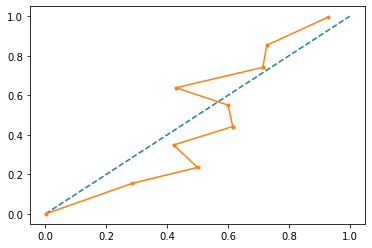

In [9]:
probs = rf_Calibrated.predict_proba(X_test)[:,1]
a, b = calibration_curve(y_test, probs, n_bins=10, normalize=True)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(a, b, marker='.')

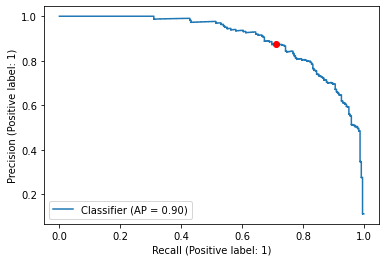

In [10]:
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

**Recall and precision are both quite decent; we will try to tune the model to improve performance.**

# Tuning Hyperparameters

**SMOTE must be part of the imblearn.pipeline so it isn't applied to the validation folds.**

In [11]:
rf_2 = Pipeline([('smote',SMOTE()),('classifier',RandomForestClassifier(n_jobs = -1,warm_start=True))])
parameter_grid = {'classifier__n_estimators':[100, 250, 400],'classifier__max_depth':[5, 7, 10],'classifier__min_samples_leaf':[5, 10, 15]}

gridsearch = GridSearchCV(rf_2, parameter_grid, cv=5, n_jobs=-1, scoring=['recall','f1'],refit='f1')
Calibrated_rf_2 = CalibratedClassifierCV(gridsearch, n_jobs=-1)
Calibrated_rf_2.fit(X_dev,y_dev)

CalibratedClassifierCV(base_estimator=GridSearchCV(cv=5,
                                                   estimator=Pipeline(steps=[('smote',
                                                                              SMOTE()),
                                                                             ('classifier',
                                                                              RandomForestClassifier(n_jobs=-1,
                                                                                                     warm_start=True))]),
                                                   n_jobs=-1,
                                                   param_grid={'classifier__max_depth': [5,
                                                                                         7,
                                                                                         10],
                                                               'classifier__min_samples_leaf': [5,
   

In [12]:
rf_2_Calibrated_predictions = Calibrated_rf_2.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,rf_2_Calibrated_predictions)}')
print(f'Recall: {recall_score(y_test,rf_2_Calibrated_predictions)}')
print(f'Precision: {precision_score(y_test,rf_2_Calibrated_predictions)}')
print(f'F-1 Score: {f1_score(y_test,rf_2_Calibrated_predictions)}')

recall, precision = recall_score(y_test,rf_2_Calibrated_predictions), precision_score(y_test,rf_2_Calibrated_predictions)

Accuracy: 0.9988220737441228
Recall: 0.8530612244897959
Precision: 0.7157534246575342
F-1 Score: 0.7783985102420856


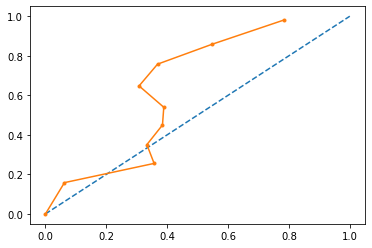

In [13]:
probs = Calibrated_rf_2.predict_proba(X_test)[:,1]
a, b = calibration_curve(y_test, probs, n_bins=10, normalize=True)

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(a, b, marker='.')

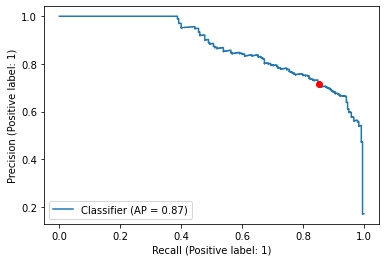

In [14]:
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

**If we let the threshold be 0.18, we get the following results...**

We can achieve a precision of 0.662 and a recall of 0.943


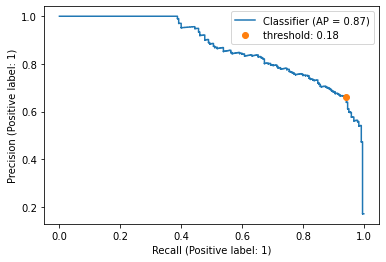

In [16]:
PrecisionRecallDisplay.from_predictions(y_test, probs)
threshold=.18
pred = (Calibrated_rf_2.predict_proba(X_test)[:,1]>=.18).astype(bool)

recall, precision = recall_score(y_test,pred), precision_score(y_test,pred)
plt.plot(recall,precision,'o',label=f'threshold: {threshold}');
plt.legend()

print(f'We can achieve a precision of {precision_score(y_test,pred):0.3f} and a recall of {recall_score(y_test,pred):0.3f}')

In [17]:
print(f'Accuracy: {accuracy_score(y_test,pred)}')
print(f'Recall: {recall_score(y_test,pred)}')
print(f'Precision: {precision_score(y_test,pred)}')
print(f'F-1 Score: {f1_score(y_test,pred)}')

recall, precision = recall_score(y_test,pred), precision_score(y_test,pred)

Accuracy: 0.9986933927245731
Recall: 0.9428571428571428
Precision: 0.66189111747851
F-1 Score: 0.7777777777777778


In [18]:
filename = '../processing/RandomForest.sav'
pickle.dump(Calibrated_rf_2, open(filename, 'wb'))